In [1]:
import zipfile
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')


In [3]:
# Pandas and Numpy for data structures and util fucntions
import numpy as np
#pip install pandas
import pandas as pd
from numpy.random import rand

In [1]:

train_folder = 'cat_dog/cat_dog/'
#test_folder = '/content/test/'

In [4]:
data_labels = pd.read_csv('cat_dog/cat_dog.csv')
data_labels.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [5]:
data_labels=data_labels[:8000]

In [7]:
target_labels = data_labels['labels']
len(set(target_labels))

2

In [8]:
from keras import regularizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50

In [9]:
# Pandas and Numpy for data structures and util fucntions
import numpy as np
#pip install pandas
import pandas as pd
from numpy.random import rand

pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn.model_selection import train_test_split
# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

In [10]:
# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [11]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
print(labels_ohe.shape)
print(labels_ohe[:2])

(8000, 2)
[[0 1]
 [1 0]]


In [13]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["image"] ), axis=1)
data_labels.head()

,image,labels,image_path
0,dog.11289.jpg,1,cat_dog/cat_dog/dog.11289.jpg
1,cat.10836.jpg,0,cat_dog/cat_dog/cat.10836.jpg
2,cat.7970.jpg,0,cat_dog/cat_dog/cat.7970.jpg
3,cat.2212.jpg,0,cat_dog/cat_dog/cat.2212.jpg
4,dog.2653.jpg,1,cat_dog/cat_dog/dog.2653.jpg


In [14]:
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(224, 224))
                       ) for img 
                           in data_labels['image_path'].values.tolist()
                      ]).astype('float32')

In [15]:
train_data.shape

(8000, 224, 224, 3)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.2, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [17]:
x_train.shape, x_test.shape

((6400, 224, 224, 3), (1600, 224, 224, 3))

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [19]:
x_train.shape, x_val.shape

((5440, 224, 224, 3), (960, 224, 224, 3))

In [20]:
y_train_ohe = pd.get_dummies(y_train, sparse=True)
y_train_ohe = np.asarray(y_train_ohe)

y_test_ohe = pd.get_dummies(y_test, sparse=True)
y_test_ohe = np.asarray(y_test_ohe)

y_val_ohe = pd.get_dummies(y_val, sparse=True)
y_val_ohe = np.asarray(y_val_ohe)

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((5440, 2), (1600, 2), (960, 2))

In [21]:
BATCH_SIZE = 32

In [22]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [23]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=1)

In [24]:
# Get the InceptionV3 model so we can do transfer learning
base_resnet = ResNet50(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

In [26]:


model = Sequential()
model.add(base_resnet)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))


In [27]:
for layer in base_resnet.layers[:143]:
        layer.trainable = False

In [28]:
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=.0001),
                  metrics=['accuracy'])
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              verbose=1)

Epoch 1/15
170/170 [==============================] - 76s 406ms/step - loss: 0.9632 - accuracy: 0.5651 - val_loss: 1.6319 - val_accuracy: 0.5000
Epoch 2/15
170/170 [==============================] - 82s 480ms/step - loss: 0.8568 - accuracy: 0.5906 - val_loss: 1.2007 - val_accuracy: 0.5437
Epoch 3/15
170/170 [==============================] - 82s 484ms/step - loss: 0.8615 - accuracy: 0.5831 - val_loss: 0.7107 - val_accuracy: 0.6323
Epoch 4/15
170/170 [==============================] - 76s 450ms/step - loss: 0.8429 - accuracy: 0.5952 - val_loss: 0.6670 - val_accuracy: 0.6250
Epoch 5/15
170/170 [==============================] - 76s 448ms/step - loss: 0.7917 - accuracy: 0.6061 - val_loss: 0.7071 - val_accuracy: 0.5583
Epoch 6/15
170/170 [==============================] - 70s 414ms/step - loss: 0.7827 - accuracy: 0.6119 - val_loss: 0.9251 - val_accuracy: 0.5594
Epoch 7/15
170/170 [==============================] - 71s 418ms/step - loss: 0.7515 - accuracy: 0.6230 - val_loss: 0.6702 - val_ac

In [29]:
model.save('cat_dog_resnet50.hdf5')

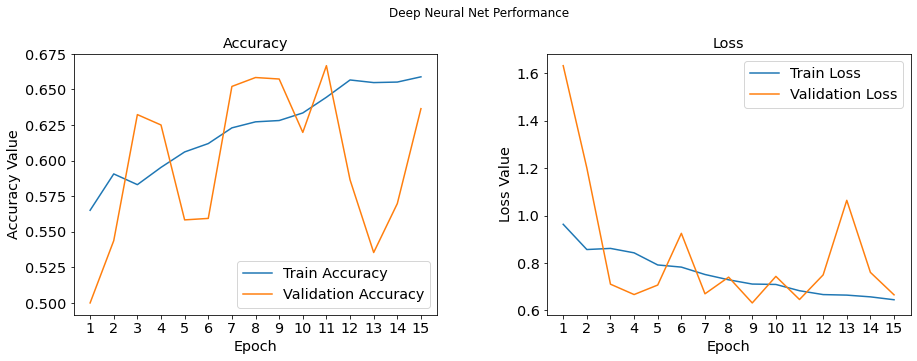

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
# scaling test features
x_test /= 255.

In [32]:
test_predictions = model.predict(x_test)
test_predictions

array([[0.52605516, 0.4739448 ],
       [0.20933309, 0.79066694],
       [0.28277287, 0.7172271 ],
       ...,
       [0.01193218, 0.98806787],
       [0.8296931 , 0.17030688],
       [0.48810357, 0.51189643]], dtype=float32)

In [33]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()


,0,1
0,0.526055,0.473945
1,0.209333,0.790667
2,0.282773,0.717227
3,0.614119,0.385881
4,0.499319,0.500681


In [34]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

[0, 1, 1, 0, 1, 0, 1, 1, 1, 1]

In [35]:
#Making prediction
y_pred=model.predict(x_test)
y_true=np.argmax(y_test_ohe,axis=1)

In [36]:
loss, accuracy = model.evaluate(x_test, y_test_ohe, verbose=0)

In [37]:
print(loss)
print(accuracy)

0.585492730140686
0.6887500286102295


In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
target_names=['class 0', 'class 1']
print(classification_report(y_true, y_pred_bool, target_names=target_names))
#print(classification_report(y_true, y_pred_bool))

25/25 [==============================] - 4s 87ms/step
              precision    recall  f1-score   support

     class 0       0.87      0.44      0.59       798
     class 1       0.63      0.93      0.75       802

    accuracy                           0.69      1600
   macro avg       0.75      0.69      0.67      1600
weighted avg       0.75      0.69      0.67      1600



In [39]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [40]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred_bool)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

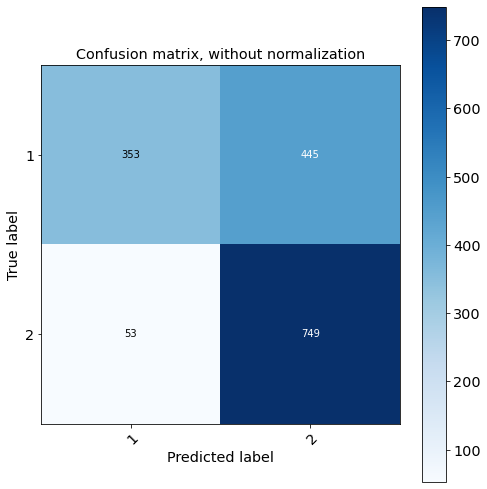

In [41]:
#Defining the class labels
class_names=[1,2]

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_bool, classes = class_names, title='Confusion matrix, without normalization')
